# CNN Training

Target of this code is to train a CNN network to classify images of a digital readout to the digits 0 to 9. Additionally a category "NaN" is introduced, to mark images that are not amibiguous.

### Preparing the training
* First all libraries are loaded
    * It is assumed, that they are installed during the Python setup
* matplotlib is set to print the output inline in the jupyter notebook

In [1]:
########### Basic Parameters for Running: ################################
    
TFliteNamingAndVersion = "dig1200s3"   # Used for tflite Filename
Training_Percentage = 0.0              # 0.0 = Use all Images for Training
Epoch_Anz = 500

##########################################################################


import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import os
import numpy as np
from sklearn.utils import shuffle
from tensorflow.python import keras
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import History 
from tensorflow.keras.utils import to_categorical
from PIL import Image 
from pathlib import Path

loss_ges = np.array([])
val_loss_ges = np.array([])

%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

### Load training data
* The data is expected in the "Input_dir"
* Inside subdirectories are expected from -1, 0, 1, ... 9 in which the pictures are sorted according to their values (=category)
* Picture size must be 20x32 with 3 color channels (RGB)
* The filename can be arbitrary

* The images are stored in the x_data[]
* The expected category for each image in the corresponding y_data[]

* The last step is a shuffle (from sklearn.utils) and split the data into training and validation data

In [2]:
Input_dir='ziffer_sortiert_resize'

files = glob.glob(Input_dir + '/*.jpg')
x_data = []
y_data = []

for aktfile in files:
    base = os.path.basename(aktfile)
    target = base[0:1]
    if target == "N":
        category = 10                # NaN does not work --> convert to 10
    else:
        category = int(target)
    test_image = Image.open(aktfile)
    test_image = np.array(test_image, dtype="float32")
    x_data.append(test_image)
    y_data.append(np.array([category]))

x_data = np.array(x_data)
y_data = np.array(y_data)
y_data = to_categorical(y_data, 11)
print(x_data.shape)
print(y_data.shape)

x_data, y_data = shuffle(x_data, y_data)

if (Training_Percentage > 0):
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Training_Percentage)
else:
    X_train = x_data
    y_train = y_data

(1460, 32, 20, 3)
(1460, 11)


### Define the model

The layout of the network ist a typcial CNN network with alternating **Conv2D** and **MaxPool2D** layers. Finished after **flattening** with additional **Dense** layer.

#### Important
* Shape of the input layer: (32, 20, 3)
* Number of output layers: 11
* As loss function "categorical_crossentropy" is choosen, as it is a categories task

In [3]:
model = Sequential()
model.add(BatchNormalization(input_shape=(32,20,3)))
model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(11, activation = "softmax"))
model.summary()

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95), metrics = ["accuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 32, 20, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 20, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 10, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 10, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 5, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 5, 32)          9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 2, 32)          0

# Training
The input pictures are randomly scattered for brightness, pixel shift variations and rotation angle. This is implemented with a ImageDataGenerator.


In [4]:
Batch_Size = 4
Shift_Range = 1
Brightness_Range = 0.3
Rotation_Angle = 10
ZoomRange = 0.4

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], 
                             height_shift_range=[-Shift_Range,Shift_Range],
                             brightness_range=[1-Brightness_Range,1+Brightness_Range],
                             zoom_range=[1-ZoomRange, 1+ZoomRange],
                             rotation_range=Rotation_Angle)

if (Training_Percentage > 0):
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)
    history = model.fit(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    history = model.fit(train_iterator, epochs = Epoch_Anz)



Epoch 1/500
365/365 [==============================] - 5s 9ms/step - loss: 2.1367 - accuracy: 0.3063
Epoch 2/500
365/365 [==============================] - 3s 9ms/step - loss: 1.3820 - accuracy: 0.5556
Epoch 3/500
365/365 [==============================] - 3s 8ms/step - loss: 1.0241 - accuracy: 0.6643
Epoch 4/500
365/365 [==============================] - 3s 8ms/step - loss: 0.8692 - accuracy: 0.7235
Epoch 5/500
365/365 [==============================] - 3s 9ms/step - loss: 0.9129 - accuracy: 0.7215
Epoch 6/500
365/365 [==============================] - 3s 9ms/step - loss: 0.6589 - accuracy: 0.8040
Epoch 7/500
365/365 [==============================] - 3s 9ms/step - loss: 0.6961 - accuracy: 0.7960
Epoch 8/500
365/365 [==============================] - 3s 9ms/step - loss: 0.6643 - accuracy: 0.8037
Epoch 9/500
365/365 [==============================] - 3s 9ms/step - loss: 0.5883 - accuracy: 0.8086
Epoch 10/500
365/365 [==============================] - 3s 9ms/step - loss: 0.5365 - accura

365/365 [==============================] - 3s 9ms/step - loss: 0.1478 - accuracy: 0.9539
Epoch 81/500
365/365 [==============================] - 3s 9ms/step - loss: 0.1566 - accuracy: 0.9603
Epoch 82/500
365/365 [==============================] - 3s 9ms/step - loss: 0.1705 - accuracy: 0.9537
Epoch 83/500
365/365 [==============================] - 3s 9ms/step - loss: 0.1628 - accuracy: 0.9497
Epoch 84/500
365/365 [==============================] - 3s 8ms/step - loss: 0.1243 - accuracy: 0.9624
Epoch 85/500
365/365 [==============================] - 3s 8ms/step - loss: 0.1084 - accuracy: 0.9575
Epoch 86/500
365/365 [==============================] - 3s 8ms/step - loss: 0.1129 - accuracy: 0.9705
Epoch 87/500
365/365 [==============================] - 3s 8ms/step - loss: 0.1074 - accuracy: 0.9666
Epoch 88/500
365/365 [==============================] - 3s 9ms/step - loss: 0.1426 - accuracy: 0.9613
Epoch 89/500
365/365 [==============================] - 3s 8ms/step - loss: 0.1530 - accuracy: 

365/365 [==============================] - 3s 9ms/step - loss: 0.0725 - accuracy: 0.9803
Epoch 160/500
365/365 [==============================] - 3s 9ms/step - loss: 0.0968 - accuracy: 0.9733
Epoch 161/500
365/365 [==============================] - 3s 9ms/step - loss: 0.0405 - accuracy: 0.9835
Epoch 162/500
365/365 [==============================] - 3s 9ms/step - loss: 0.0532 - accuracy: 0.9799
Epoch 163/500
365/365 [==============================] - 3s 9ms/step - loss: 0.0607 - accuracy: 0.9804
Epoch 164/500
365/365 [==============================] - 3s 8ms/step - loss: 0.0760 - accuracy: 0.9828
Epoch 165/500
365/365 [==============================] - 3s 8ms/step - loss: 0.0829 - accuracy: 0.9739
Epoch 166/500
365/365 [==============================] - 3s 9ms/step - loss: 0.0674 - accuracy: 0.9764
Epoch 167/500
365/365 [==============================] - 3s 8ms/step - loss: 0.0377 - accuracy: 0.9904
Epoch 168/500
365/365 [==============================] - 3s 9ms/step - loss: 0.1026 - a

365/365 [==============================] - 3s 9ms/step - loss: 0.0383 - accuracy: 0.9841
Epoch 239/500
365/365 [==============================] - 3s 9ms/step - loss: 0.0578 - accuracy: 0.9768
Epoch 240/500
365/365 [==============================] - 3s 9ms/step - loss: 0.0712 - accuracy: 0.9764
Epoch 241/500
365/365 [==============================] - 3s 9ms/step - loss: 0.0797 - accuracy: 0.9800
Epoch 242/500
365/365 [==============================] - 3s 9ms/step - loss: 0.0464 - accuracy: 0.9790
Epoch 243/500
365/365 [==============================] - 3s 9ms/step - loss: 0.0701 - accuracy: 0.9824
Epoch 244/500
365/365 [==============================] - 3s 9ms/step - loss: 0.0483 - accuracy: 0.9844
Epoch 245/500
365/365 [==============================] - 3s 9ms/step - loss: 0.0671 - accuracy: 0.9784
Epoch 246/500
365/365 [==============================] - 3s 9ms/step - loss: 0.0437 - accuracy: 0.9823
Epoch 247/500
365/365 [==============================] - 3s 9ms/step - loss: 0.0435 - a

365/365 [==============================] - 3s 9ms/step - loss: 0.0325 - accuracy: 0.9864
Epoch 318/500
365/365 [==============================] - 3s 9ms/step - loss: 0.0583 - accuracy: 0.9836
Epoch 319/500
365/365 [==============================] - 3s 9ms/step - loss: 0.0333 - accuracy: 0.9866
Epoch 320/500
365/365 [==============================] - 3s 9ms/step - loss: 0.0655 - accuracy: 0.9818
Epoch 321/500
365/365 [==============================] - 3s 9ms/step - loss: 0.0623 - accuracy: 0.9839
Epoch 322/500
365/365 [==============================] - 3s 9ms/step - loss: 0.0281 - accuracy: 0.9885
Epoch 323/500
365/365 [==============================] - 3s 9ms/step - loss: 0.0398 - accuracy: 0.9888
Epoch 324/500
365/365 [==============================] - 3s 9ms/step - loss: 0.0438 - accuracy: 0.9863
Epoch 325/500
365/365 [==============================] - 3s 9ms/step - loss: 0.0564 - accuracy: 0.9851
Epoch 326/500
365/365 [==============================] - 3s 9ms/step - loss: 0.0639 - a

365/365 [==============================] - 3s 9ms/step - loss: 0.0320 - accuracy: 0.9914: 0s - loss: 0
Epoch 397/500
365/365 [==============================] - 3s 8ms/step - loss: 0.0489 - accuracy: 0.9824
Epoch 398/500
365/365 [==============================] - 3s 9ms/step - loss: 0.0688 - accuracy: 0.9905
Epoch 399/500
365/365 [==============================] - 3s 9ms/step - loss: 0.0470 - accuracy: 0.9862
Epoch 400/500
365/365 [==============================] - 3s 9ms/step - loss: 0.0457 - accuracy: 0.9886
Epoch 401/500
365/365 [==============================] - 3s 9ms/step - loss: 0.0324 - accuracy: 0.9928: 0s - loss: 0.0321 - accuracy
Epoch 402/500
365/365 [==============================] - 3s 9ms/step - loss: 0.0887 - accuracy: 0.9771: 0s - loss: 0.0879 - 
Epoch 403/500
365/365 [==============================] - 3s 9ms/step - loss: 0.0192 - accuracy: 0.9913
Epoch 404/500
365/365 [==============================] - 3s 9ms/step - loss: 0.0548 - accuracy: 0.9871
Epoch 405/500
365/365

365/365 [==============================] - 3s 8ms/step - loss: 0.0304 - accuracy: 0.9907
Epoch 475/500
365/365 [==============================] - 3s 8ms/step - loss: 0.0731 - accuracy: 0.9857
Epoch 476/500
365/365 [==============================] - 3s 8ms/step - loss: 0.0534 - accuracy: 0.9868
Epoch 477/500
365/365 [==============================] - 3s 8ms/step - loss: 0.0828 - accuracy: 0.9826
Epoch 478/500
365/365 [==============================] - 3s 8ms/step - loss: 0.0221 - accuracy: 0.9877
Epoch 479/500
365/365 [==============================] - 3s 8ms/step - loss: 0.0488 - accuracy: 0.9847
Epoch 480/500
365/365 [==============================] - 3s 8ms/step - loss: 0.0289 - accuracy: 0.9880: 0s
Epoch 481/500
365/365 [==============================] - 3s 8ms/step - loss: 0.0546 - accuracy: 0.9806
Epoch 482/500
365/365 [==============================] - 3s 8ms/step - loss: 0.0332 - accuracy: 0.9907
Epoch 483/500
365/365 [==============================] - 3s 7ms/step - loss: 0.0364

### Learing result
 
* Visualization of the training and validation results

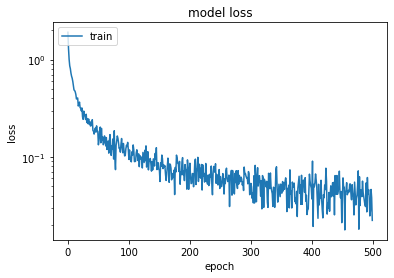

In [5]:
loss_ges = np.append(loss_ges, history.history['loss'])
plt.semilogy(history.history['loss'])

if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Check the model by hand

* The following code uses the trained model to check the deviation for each picture.
* x-axis walks through each pixel, y-axis shows the result

### Check each image for expected and deviation
* setting the switch "only_deviation = true" will only print the images for which the classification and the CNN-result deviates

The output contains the following information:

| Filename      | Expected Category           | Predicted Category        |
|------------- |:-----------------------------:|--------------|
| ziffer_sortiert_resize_NaN/5\Ziffer_4_0034.jpg | 4  | -1 |


ziffer_sortiert_resize\0_digit1_310410.jpg 0 9


ziffer_sortiert_resize\2_10_dig6_20210726-190157.jpg 2 -1


ziffer_sortiert_resize\3_1_ht4_20210627-124615.jpg 3 -1


ziffer_sortiert_resize\4_10_dig4_20210709-181251.jpg 4 -1


ziffer_sortiert_resize\4_4_dig6_20210724-184309.jpg 4 -1


ziffer_sortiert_resize\7_10_dig6_20210727-150532.jpg 7 -1


ziffer_sortiert_resize\8_3_dig6_20210716-214753.jpg 8 0


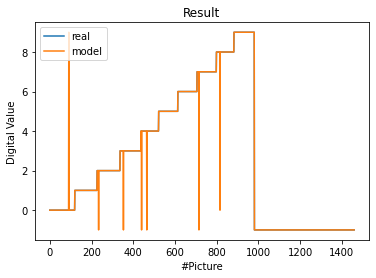

In [6]:
Input_dir='ziffer_sortiert_resize'
res = []
only_deviation = True
show_wrong_image = True

files = glob.glob(Input_dir + '/*.jpg')

for aktfile in files:
    base = os.path.basename(aktfile)
    target = base[0:1]
    if target == "N":
        zw1 = -1
    else:
        zw1 = int(target)
    expected_class = zw1
    image_in = Image.open(aktfile)
    test_image = np.array(image_in, dtype="float32")
    img = np.reshape(test_image,[1,32,20,3])
    classes = np.argmax(model.predict(img), axis=-1)
    classes = classes[0]
    if classes == 10: 
        classes = -1
    zw2 = classes
    zw3 = zw2 - zw1
    res.append(np.array([zw1, zw2, zw3]))
    if only_deviation == True:
        if str(classes) != str(expected_class):
            print(aktfile + " " + str(expected_class) +  " " + str(classes))
            if show_wrong_image == True:
                display(image_in)
    else:
        print(aktfile + " " + aktsubdir +  " " + str(classes))
        

res = np.asarray(res)


plt.plot(res[:,0])
plt.plot(res[:,1])
plt.title('Result')
plt.ylabel('Digital Value')
plt.xlabel('#Picture')
plt.legend(['real','model'], loc='upper left')
plt.show()

### Save the model

* Save the model to the file with the "h5" file format

In [7]:
FileName = TFliteNamingAndVersion

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(FileName + ".tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpcqxi7vg7\assets


219388

In [8]:
FileName = TFliteNamingAndVersion + "q.tflite"

import tensorflow as tf

def representative_dataset():
    for n in range(x_data[0].size):
      data = np.expand_dims(x_data[5], axis=0)
      yield [data.astype(np.float32)]
        
converter2 = tf.lite.TFLiteConverter.from_keras_model(model)
converter2.representative_dataset = representative_dataset
converter2.optimizations = [tf.lite.Optimize.DEFAULT]
converter2.representative_dataset = representative_dataset
tflite_quant_model = converter2.convert()

open(FileName, "wb").write(tflite_quant_model)
print(FileName)
Path(FileName).stat().st_size

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpnvig9r3q\assets


INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpnvig9r3q\assets


dig1200s3q.tflite


63824

Checking the images shows, that this are border line images, which can be interpreted as a good digit or a faulty one.